### III: Modelling & Tuning

In this notebook, onece done with processing the data, EDA and sentiment analysis, we can now proceed with training our model. We will explore different type of models, evaluate them and then do hyperparameter tuning to achieve the best scores.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,  roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,HalvingGridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')


In [2]:
combined = pd.read_csv('datasets/combined.csv')

combined.shape

(60778, 12)

In [3]:
combined.head()

,Unnamed: 0,id,date,title,selftext,n_comments,author,comment,Subreddit,sentences,words,preprocessed_words
0,0,16d4gg0,2023-09-08 08:04:04,New to pc building,What’s better rtx 3090 for 700$-I’ve seen thes...,1.0,43VerLoner,3090 keeps its price from the VRAM it has. A 4...,Nvidia,"['3090 keeps its price from the VRAM it has.',...","['3090', 'keeps', 'its', 'price', 'from', 'the...",keep price vram tad slower access frame genera...
1,1,16d46z5,2023-09-08 07:47:35,Experiences,I personally play on a typical 1080ti system(...,7.0,SEALEJ2001,"It's not you, just a combo of the game running...",Nvidia,"[""It's not you, just a combo of the game runni...","['It', ""'s"", 'not', 'you', ',', 'just', 'a', '...",combo game running like pig older gpu showing ...
2,2,16d46z5,2023-09-08 07:47:35,Experiences,I personally play on a typical 1080ti system(...,7.0,SEALEJ2001,"Starfield is CPU heavy, which one do you have?...",Nvidia,"['Starfield is CPU heavy, which one do you hav...","['Starfield', 'is', 'CPU', 'heavy', ',', 'whic...",starfield cpu heavy one great ti gpu probably ...
3,3,16d46z5,2023-09-08 07:47:35,Experiences,I personally play on a typical 1080ti system(...,7.0,SEALEJ2001,The game is just awfully optimized. I just upg...,Nvidia,"['The game is just awfully optimized.', 'I jus...","['The', 'game', 'is', 'just', 'awfully', 'opti...",game awfully optimized upgraded ti like month ...
4,4,16d46z5,2023-09-08 07:47:35,Experiences,I personally play on a typical 1080ti system(...,7.0,SEALEJ2001,I tried using fsr but I didn't see any noticib...,Nvidia,"[""I tried using fsr but I didn't see any notic...","['I', 'tried', 'using', 'fsr', 'but', 'I', 'di...",tried using fsr nt see noticible improvement w...


In [4]:
# select X and y columns we need
df =  combined[['Subreddit', 'preprocessed_words']]

# add label for classification
df['is_amd'] = df['Subreddit'].apply(lambda x: 1 if x == "AMD" else 0)
df = df.drop(columns = 'Subreddit')
df = df.rename(columns={'preprocessed_words':'text'})

In [5]:
df.head()

,text,is_amd
0,keep price vram tad slower access frame genera...,0
1,combo game running like pig older gpu showing ...,0
2,starfield cpu heavy one great ti gpu probably ...,0
3,game awfully optimized upgraded ti like month ...,0
4,tried using fsr nt see noticible improvement w...,0


In [6]:
# Specify Stopwords
custom_stopwords = [ "subreddit", "reddit"]  # remove these words as it is not meaningful for our analysis
stopwords_list = list(set(stopwords.words('english') + custom_stopwords))

In [7]:
# Let's also import the top common words of both subreddits from Notebook 2
common_words = pd.read_csv('datasets/common_words.csv',index_col=[0])
common_words_30 = common_words.head(20)

# Create an additional stopwords list that includes the top 10 common words
stopwords_list_with_common =  list(set(stopwords.words('english') + custom_stopwords + common_words_30['0'].values.tolist()))

In [8]:
stopwords_list_with_common

['have',
 'didn',
 'he',
 'are',
 'few',
 "you'd",
 'its',
 'itself',
 'those',
 'card',
 'yours',
 'what',
 'such',
 "hasn't",
 'some',
 'the',
 'on',
 'amd',
 'other',
 'yourself',
 'her',
 'most',
 "that'll",
 'through',
 "you're",
 'that',
 'like',
 'while',
 'one',
 'or',
 'than',
 'wasn',
 'been',
 "hadn't",
 'so',
 "doesn't",
 'not',
 'wouldn',
 'is',
 "she's",
 'i',
 'if',
 'mustn',
 'get',
 'under',
 'any',
 "shan't",
 'our',
 'good',
 'for',
 'hadn',
 'own',
 'again',
 'why',
 't',
 'yourselves',
 "needn't",
 'you',
 "won't",
 'having',
 'just',
 'was',
 'we',
 'then',
 'even',
 'at',
 'be',
 'each',
 'should',
 'and',
 'they',
 'will',
 'it',
 'this',
 "you'll",
 'o',
 'down',
 'performance',
 "weren't",
 'subreddit',
 're',
 'haven',
 'won',
 'himself',
 'until',
 'them',
 'these',
 'above',
 'by',
 'an',
 'only',
 'up',
 'of',
 'nor',
 'do',
 'll',
 'where',
 "should've",
 'me',
 'were',
 'games',
 'all',
 'about',
 "mustn't",
 'below',
 'd',
 'dlss',
 'aren',
 'game',
 'h

For this notebook on Modelling, I will only be considering the "text" column of the scraped dataset, and this has been pre-processed in notebook 2. This ensures that our model can be properly trained on the content of the subreddit posts.


##### Baseline 
We always begin with creating a baseline model so that we have something to compare our model against. We can use the normalized value of y. This represents the simplest model we can use, where assigning a post randomly will give us a 63% chance of classifying it correctly.

In [9]:
# Baseline model
X = df['text']
y = df['is_amd']
y.value_counts(normalize=True)

is_amd
1    0.629734
0    0.370266
Name: proportion, dtype: float64

#### Model Preparation


Steps I took for this section:
1. Train Test Split
2. Instantiating Vectorizers and Models
3. Creating a User-Defined Function* with Scikit-learn's Pipeline tool that will help calculate the relevant classification metrics from each model (Metrics include Accuracy, Specificity and F1_Score)
4. Evaluate best model
5. Tune Hyper-parameters of best model



In [10]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = y)
X_train = X_train.values.astype('U')
X_test = X_test.values.astype('U')
print(X_train.shape)
print(X_test.shape)

(48622,)
(12156,)


In [11]:
cvec = CountVectorizer(stop_words=stopwords_list)
cvec.fit(X_train)
X_train = cvec.transform(X_train) #transform the corpus

In [12]:
print(cvec.get_feature_names_out())
print(X_train.shape)

['aa' 'aaa' 'aaaaa' ... 'zz' 'zzx' 'zzzzz']
(48622, 30358)


In [13]:
# Transform test
X_test = cvec.transform(X_test)

##### 1. Train Test Split

In [14]:
# Redefine train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = y)
X_train = X_train.values.astype('U')
X_test = X_test.values.astype('U')

In [15]:
X_train

array(['must something weird nanite sure honest maybe potato quality wanted console fps update pc guessing though',
       'deleted', 'switch port doesnt fsr', ...,
       'x either look x suppose since pretty much gaming mostly',
       'yeah weird even weirder none dx advertised performance advantage ever materialised regular game guess game developer decided use freed resource make game even le optimized',
       'got mine friday take place massive improvement wish fsr could remove jaggies shinies well dl'],
      dtype='<U4199')

##### 2. Instantiation of Vectorizers and Models

2.1. I will be exploring different Classification algorithms:
- Multinomial Naive Bayes: Based on Bayes's theorem - the assumption that each feature (in our case, each word) is independent of each other.
- Logistic Regression:
- Random Forest: Consists of n number of decision trees that act as an ensemble. Each decision tree makes a class prediction and the class with the most votes becomes the model's prediction.  
- K-nearest Neighbors Classifier  

2.2. I will also be evaluating the models using both Count Vectorizer or Term Frequency-Inverse Document Frequency (TFIDF) transformers:
- Count Vectorizer: Takes every word as a token, and uses it as a feature.
- TFIFD: accounts for frequency of a word in a given document and the frequency between documents. Word importance increases proportionally to the number of times it appears in a document, but is offset by frequency of word in entire corpus.

In [16]:
# Instiantiate models
models = {'nb': MultinomialNB(),
          'log_reg': LogisticRegression(max_iter=500, random_state=123),
          'rf': RandomForestClassifier(random_state=123),
          'knn': KNeighborsClassifier()}

##### 3. User-Defined Function - inputs required are vectorizer and model

3.1 Ngram Range option: To explore if different n-grams will give better results. I have opted to include this based on the EDA in Notebook 2 - seems like some bigrams and trigrams might be good predictors of whether or not a Subreddit is from AMD or Nvidia. <br>

3.2 List of Stopwords: Explore if the standard stopword list in nltk of English words or English words + common words from both subreddits will produce better results. By removing them, I am retaining the words that are more specific to the content of each subreddit. This might enhance the model's ability to capture the distinctive language and topics associated with each community, hence improving model performance.

3.3 Function will produce a dataframe of classification results: Accuracy, Specificity, F_Score, ROC_AUC

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

df_results = []

def clf_model(vec, mod, stopwords, ngram_range, cv_num,type):   # option to include Grid Search

    vec_params={}
    results = {}
    vec_params['ngram_range'] = ngram_range  # Add ngram_range to the vectorizer parameters
    vec_params['stop_words'] = stopwords
    
    # Instantiate Vectorizers
    if vec == 'cvec':     
        vectorizer = CountVectorizer(**vec_params)
    elif vec == 'tvec':
        vectorizer = TfidfVectorizer(**vec_params)
    else:
        raise ValueError("Invalid 'vec' parameter. Supported values are 'cvec' and 'tvec'.")
    
    pipe = Pipeline([
            (vec, vectorizer), 
            (mod, models[mod])
            ])     # pipeline helps to automatically transform the data

    pipe.fit(X_train, y_train)
    
    # Get predictions
    preds = pipe.predict(X_test)

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    acc = (tp + tn)/ (tp+tn+fp+fn)
    spec = tn / (tn + fp)
    
    # Retrieve metrics
    results['Model'] = mod
    results['Vectorizer'] = vec
    results['Train Score'] = pipe.score(X_train, y_train)
    results['Test Score'] = pipe.score(X_test, y_test)
    results['Accuracy'] = acc
    results['Specificity'] = spec
    results['f_score'] = f1_score(y_test, preds)
    results['ROC_AUC'] = roc_auc_score(y_test, preds)
    results['Ngram Range'] = ngram_range
    results['Stopword List'] = type
        
    df_results.append(results)
    
    print(f"--- METRICS for {mod},{vec} ---")
    display(results)
    
    

In [21]:
# Logistic Regression

clf_model('cvec', 'log_reg', stopwords_list_with_common, (1,1), 5,"Stop Words List with Common Words")
clf_model('cvec', 'log_reg', stopwords_list, (1,1), 5 ,"Stop Words List with English Words")
clf_model('cvec', 'log_reg', stopwords_list_with_common, (1,2), 5,"Stop Words List with Common Words")
clf_model('cvec', 'log_reg', stopwords_list, (1,2), 5 ,"Stop Words List with English Words")
clf_model('cvec', 'log_reg', stopwords_list_with_common, (1,3), 5,"Stop Words List with Common Words")
clf_model('cvec', 'log_reg', stopwords_list, (1,3), 5 ,"Stop Words List with English Words")
clf_model('tvec', 'log_reg', stopwords_list_with_common, (1,1), 5,"Stop Words List with Common Words")
clf_model('tvec', 'log_reg', stopwords_list, (1,1), 5 ,"Stop Words List with English Words")
clf_model('tvec', 'log_reg', stopwords_list_with_common, (1,2), 5,"Stop Words List with Common Words")
clf_model('tvec', 'log_reg', stopwords_list, (1,2), 5 ,"Stop Words List with English Words")
clf_model('tvec', 'log_reg', stopwords_list_with_common, (1,3), 5,"Stop Words List with Common Words")
clf_model('tvec', 'log_reg', stopwords_list, (1,3), 5 ,"Stop Words List with English Words")


--- METRICS for log_reg,cvec ---


{'Model': 'log_reg',
 'Vectorizer': 'cvec',
 'Train Score': 0.834005182839044,
 'Test Score': 0.7314906219151036,
 'Accuracy': 0.7314906219151036,
 'Specificity': 0.5189957787158409,
 'f_score': 0.8006839276990718,
 'ROC_AUC': 0.6877147410888153,
 'Ngram Range': (1, 1),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for log_reg,cvec ---


{'Model': 'log_reg',
 'Vectorizer': 'cvec',
 'Train Score': 0.8421290773723829,
 'Test Score': 0.7398815399802566,
 'Accuracy': 0.7398815399802566,
 'Specificity': 0.5478782492779383,
 'f_score': 0.8050314465408805,
 'ROC_AUC': 0.7003271063502688,
 'Ngram Range': (1, 1),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for log_reg,cvec ---


{'Model': 'log_reg',
 'Vectorizer': 'cvec',
 'Train Score': 0.9741680720661429,
 'Test Score': 0.7451464297466271,
 'Accuracy': 0.7451464297466271,
 'Specificity': 0.537880471006443,
 'f_score': 0.8107744930368922,
 'ROC_AUC': 0.7024477469336592,
 'Ngram Range': (1, 2),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for log_reg,cvec ---


{'Model': 'log_reg',
 'Vectorizer': 'cvec',
 'Train Score': 0.9783637036732343,
 'Test Score': 0.7503290556103982,
 'Accuracy': 0.7503290556103982,
 'Specificity': 0.5603199289046878,
 'f_score': 0.8130351752602724,
 'ROC_AUC': 0.7111854379990454,
 'Ngram Range': (1, 2),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for log_reg,cvec ---


{'Model': 'log_reg',
 'Vectorizer': 'cvec',
 'Train Score': 0.9784459709596479,
 'Test Score': 0.7421026653504442,
 'Accuracy': 0.7421026653504442,
 'Specificity': 0.5214396800710953,
 'f_score': 0.8098040405266032,
 'ROC_AUC': 0.6966440725633073,
 'Ngram Range': (1, 3),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for log_reg,cvec ---


{'Model': 'log_reg',
 'Vectorizer': 'cvec',
 'Train Score': 0.9824565011723089,
 'Test Score': 0.7508226390259954,
 'Accuracy': 0.7508226390259954,
 'Specificity': 0.5509886691846256,
 'f_score': 0.8144336212705998,
 'ROC_AUC': 0.7096550138868916,
 'Ngram Range': (1, 3),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for log_reg,tvec ---


{'Model': 'log_reg',
 'Vectorizer': 'tvec',
 'Train Score': 0.7871333964049196,
 'Test Score': 0.7375781507074696,
 'Accuracy': 0.7375781507074696,
 'Specificity': 0.4981115307709398,
 'f_score': 0.8082702247866331,
 'ROC_AUC': 0.688245837233935,
 'Ngram Range': (1, 1),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for log_reg,tvec ---


{'Model': 'log_reg',
 'Vectorizer': 'tvec',
 'Train Score': 0.7970260375961499,
 'Test Score': 0.7475320829220138,
 'Accuracy': 0.7475320829220138,
 'Specificity': 0.5289935569873362,
 'f_score': 0.8137855712638797,
 'ROC_AUC': 0.7025111481866791,
 'Ngram Range': (1, 1),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for log_reg,tvec ---


{'Model': 'log_reg',
 'Vectorizer': 'tvec',
 'Train Score': 0.8471885154868166,
 'Test Score': 0.7362619282658769,
 'Accuracy': 0.7362619282658769,
 'Specificity': 0.4736725172183959,
 'f_score': 0.8096425602660016,
 'ROC_AUC': 0.6821661083805892,
 'Ngram Range': (1, 2),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for log_reg,tvec ---


{'Model': 'log_reg',
 'Vectorizer': 'tvec',
 'Train Score': 0.8622434289004978,
 'Test Score': 0.7490950970714051,
 'Accuracy': 0.7490950970714051,
 'Specificity': 0.5027771606309709,
 'f_score': 0.8177581261950286,
 'ROC_AUC': 0.6983513497472293,
 'Ngram Range': (1, 2),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for log_reg,tvec ---


{'Model': 'log_reg',
 'Vectorizer': 'tvec',
 'Train Score': 0.8538315988647115,
 'Test Score': 0.7361796643632774,
 'Accuracy': 0.7361796643632774,
 'Specificity': 0.4823372583870251,
 'f_score': 0.8086857960985504,
 'ROC_AUC': 0.6838858075083395,
 'Ngram Range': (1, 3),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for log_reg,tvec ---


{'Model': 'log_reg',
 'Vectorizer': 'tvec',
 'Train Score': 0.8720743696269179,
 'Test Score': 0.7469562356038171,
 'Accuracy': 0.7469562356038171,
 'Specificity': 0.5036658520328816,
 'f_score': 0.8158304394683272,
 'ROC_AUC': 0.6968361918557615,
 'Ngram Range': (1, 3),
 'Stopword List': 'Stop Words List with English Words'}

In [22]:
# Multinomial Naive Bayes
clf_model('cvec', 'nb', stopwords_list_with_common, (1,1), 10,"Stop Words List with Common Words")
clf_model('cvec', 'nb', stopwords_list, (1,1), 10 ,"Stop Words List with English Words")
clf_model('cvec', 'nb', stopwords_list_with_common, (1,2), 10,"Stop Words List with Common Words")
clf_model('cvec', 'nb', stopwords_list, (1,2), 10 ,"Stop Words List with English Words")
clf_model('cvec', 'nb', stopwords_list_with_common, (1,3), 10,"Stop Words List with Common Words")
clf_model('cvec', 'nb', stopwords_list, (1,3), 10 ,"Stop Words List with English Words")
clf_model('tvec', 'nb', stopwords_list_with_common, (1,1), 10,"Stop Words List with Common Words")
clf_model('tvec', 'nb', stopwords_list, (1,1), 10 ,"Stop Words List with English Words")
clf_model('tvec', 'nb', stopwords_list_with_common, (1,2), 10,"Stop Words List with Common Words")
clf_model('tvec', 'nb', stopwords_list, (1,2), 10 ,"Stop Words List with English Words")
clf_model('tvec', 'nb', stopwords_list_with_common, (1,3), 10,"Stop Words List with Common Words")
clf_model('tvec', 'nb', stopwords_list, (1,3), 10 ,"Stop Words List with English Words")

--- METRICS for nb,cvec ---


{'Model': 'nb',
 'Vectorizer': 'cvec',
 'Train Score': 0.7838221381267739,
 'Test Score': 0.7314083580125041,
 'Accuracy': 0.7314083580125041,
 'Specificity': 0.5743168184847811,
 'f_score': 0.7943566164892613,
 'ROC_AUC': 0.6990460643697582,
 'Ngram Range': (1, 1),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for nb,cvec ---


{'Model': 'nb',
 'Vectorizer': 'cvec',
 'Train Score': 0.7856937188926824,
 'Test Score': 0.7370023033892728,
 'Accuracy': 0.7370023033892728,
 'Specificity': 0.6003110419906688,
 'f_score': 0.7965119979632105,
 'ROC_AUC': 0.7088426535884108,
 'Ngram Range': (1, 1),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for nb,cvec ---


{'Model': 'nb',
 'Vectorizer': 'cvec',
 'Train Score': 0.9461971946855333,
 'Test Score': 0.7357683448502796,
 'Accuracy': 0.7357683448502796,
 'Specificity': 0.42701621861808486,
 'f_score': 0.8138618451553082,
 'ROC_AUC': 0.6721625835089118,
 'Ngram Range': (1, 2),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for nb,cvec ---


{'Model': 'nb',
 'Vectorizer': 'cvec',
 'Train Score': 0.9437291760931266,
 'Test Score': 0.7431720960842383,
 'Accuracy': 0.7431720960842383,
 'Specificity': 0.44990002221728503,
 'f_score': 0.817852975495916,
 'ROC_AUC': 0.6827553670851285,
 'Ngram Range': (1, 2),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for nb,cvec ---


{'Model': 'nb',
 'Vectorizer': 'cvec',
 'Train Score': 0.9662704125704413,
 'Test Score': 0.7272951628825272,
 'Accuracy': 0.7272951628825272,
 'Specificity': 0.3528104865585425,
 'f_score': 0.8139835026092812,
 'ROC_AUC': 0.6501478951407997,
 'Ngram Range': (1, 3),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for nb,cvec ---


{'Model': 'nb',
 'Vectorizer': 'cvec',
 'Train Score': 0.969211468059726,
 'Test Score': 0.7305034550839091,
 'Accuracy': 0.7305034550839091,
 'Specificity': 0.35992001777382804,
 'f_score': 0.815913688469319,
 'ROC_AUC': 0.6541598782533412,
 'Ngram Range': (1, 3),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for nb,tvec ---


{'Model': 'nb',
 'Vectorizer': 'tvec',
 'Train Score': 0.7479947348936695,
 'Test Score': 0.7025337282000658,
 'Accuracy': 0.7025337282000658,
 'Specificity': 0.25949788935792045,
 'f_score': 0.803050108932462,
 'ROC_AUC': 0.6112642941237676,
 'Ngram Range': (1, 1),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for nb,tvec ---


{'Model': 'nb',
 'Vectorizer': 'tvec',
 'Train Score': 0.7494755460491136,
 'Test Score': 0.7040144784468575,
 'Accuracy': 0.7040144784468575,
 'Specificity': 0.26127527216174184,
 'f_score': 0.8040518462041172,
 'ROC_AUC': 0.6128061533898193,
 'Ngram Range': (1, 1),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for nb,tvec ---


{'Model': 'nb',
 'Vectorizer': 'tvec',
 'Train Score': 0.7715026119863436,
 'Test Score': 0.6667489305692662,
 'Accuracy': 0.6667489305692662,
 'Specificity': 0.11397467229504554,
 'f_score': 0.7893943332466857,
 'ROC_AUC': 0.552872378603434,
 'Ngram Range': (1, 2),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for nb,tvec ---


{'Model': 'nb',
 'Vectorizer': 'tvec',
 'Train Score': 0.7636255193122455,
 'Test Score': 0.6656794998354721,
 'Accuracy': 0.6656794998354721,
 'Specificity': 0.11086425238835815,
 'f_score': 0.788883116883117,
 'ROC_AUC': 0.5513824854365044,
 'Ngram Range': (1, 2),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for nb,tvec ---


{'Model': 'nb',
 'Vectorizer': 'tvec',
 'Train Score': 0.8165850849409733,
 'Test Score': 0.6607436656794998,
 'Accuracy': 0.6607436656794998,
 'Specificity': 0.09375694290157743,
 'f_score': 0.7868072787427626,
 'ROC_AUC': 0.5439392160621539,
 'Ngram Range': (1, 3),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for nb,tvec ---


{'Model': 'nb',
 'Vectorizer': 'tvec',
 'Train Score': 0.8051293653078854,
 'Test Score': 0.6585225403093122,
 'Accuracy': 0.6585225403093122,
 'Specificity': 0.08642523883581427,
 'f_score': 0.7858432647165041,
 'ROC_AUC': 0.5406652647477569,
 'Ngram Range': (1, 3),
 'Stopword List': 'Stop Words List with English Words'}

In [23]:
# Random Forest Model
clf_model('cvec', 'rf', stopwords_list_with_common, (1,1), 3,"Stop Words List with Common Words")
clf_model('cvec', 'rf', stopwords_list, (1,1), 3 ,"Stop Words List with English Words")
clf_model('cvec', 'rf', stopwords_list_with_common, (1,2), 3,"Stop Words List with Common Words")
clf_model('cvec', 'rf', stopwords_list, (1,2), 3 ,"Stop Words List with English Words")


--- METRICS for rf,cvec ---


{'Model': 'rf',
 'Vectorizer': 'cvec',
 'Train Score': 0.9884414462588952,
 'Test Score': 0.7207963145771635,
 'Accuracy': 0.7207963145771635,
 'Specificity': 0.5181070873139303,
 'f_score': 0.7911898609573027,
 'ROC_AUC': 0.6790404802996822,
 'Ngram Range': (1, 1),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for rf,cvec ---


{'Model': 'rf',
 'Vectorizer': 'cvec',
 'Train Score': 0.9902513265599934,
 'Test Score': 0.7361796643632774,
 'Accuracy': 0.7361796643632774,
 'Specificity': 0.5314374583425905,
 'f_score': 0.8035046872127933,
 'ROC_AUC': 0.6940008976886042,
 'Ngram Range': (1, 1),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for rf,cvec ---


{'Model': 'rf',
 'Vectorizer': 'cvec',
 'Train Score': 0.9885442803669121,
 'Test Score': 0.7226883843369529,
 'Accuracy': 0.7226883843369529,
 'Specificity': 0.4518995778715841,
 'f_score': 0.800213358620281,
 'ROC_AUC': 0.6669034140174379,
 'Ngram Range': (1, 2),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for rf,cvec ---


{'Model': 'rf',
 'Vectorizer': 'cvec',
 'Train Score': 0.990333593846407,
 'Test Score': 0.7330536360644949,
 'Accuracy': 0.7330536360644949,
 'Specificity': 0.44123528104865584,
 'f_score': 0.8101784147411524,
 'ROC_AUC': 0.6729363864420288,
 'Ngram Range': (1, 2),
 'Stopword List': 'Stop Words List with English Words'}

In [24]:
# KNN
clf_model('cvec', 'knn', stopwords_list_with_common, (1,1), 3,"Stop Words List with Common Words")
clf_model('cvec', 'knn', stopwords_list, (1,1), 3 ,"Stop Words List with English Words")
clf_model('cvec', 'knn', stopwords_list_with_common, (1,2), 3,"Stop Words List with Common Words")
clf_model('cvec', 'knn', stopwords_list, (1,2), 3 ,"Stop Words List with English Words")
clf_model('cvec', 'knn', stopwords_list_with_common, (1,3), 3,"Stop Words List with Common Words")
clf_model('cvec', 'knn', stopwords_list, (1,3), 3 ,"Stop Words List with English Words")
clf_model('tvec', 'knn', stopwords_list_with_common, (1,1), 3,"Stop Words List with Common Words")
clf_model('tvec', 'knn', stopwords_list, (1,1), 3 ,"Stop Words List with English Words")
clf_model('tvec', 'knn', stopwords_list_with_common, (1,2), 3,"Stop Words List with Common Words")
clf_model('tvec', 'knn', stopwords_list, (1,2), 3 ,"Stop Words List with English Words")
clf_model('tvec', 'knn', stopwords_list_with_common, (1,3), 3,"Stop Words List with Common Words")
clf_model('tvec', 'knn', stopwords_list, (1,3), 3 ,"Stop Words List with English Words")


--- METRICS for knn,cvec ---


{'Model': 'knn',
 'Vectorizer': 'cvec',
 'Train Score': 0.7607872979309778,
 'Test Score': 0.6307996051332675,
 'Accuracy': 0.6307996051332675,
 'Specificity': 0.4694512330593201,
 'f_score': 0.7122708039492242,
 'ROC_AUC': 0.5975603650600323,
 'Ngram Range': (1, 1),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for knn,cvec ---


{'Model': 'knn',
 'Vectorizer': 'cvec',
 'Train Score': 0.7710707087326725,
 'Test Score': 0.6436327739387957,
 'Accuracy': 0.6436327739387957,
 'Specificity': 0.48878027105087757,
 'f_score': 0.721951219512195,
 'ROC_AUC': 0.6117317423183846,
 'Ngram Range': (1, 1),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for knn,cvec ---


{'Model': 'knn',
 'Vectorizer': 'cvec',
 'Train Score': 0.7571264036855744,
 'Test Score': 0.6179664363277394,
 'Accuracy': 0.6179664363277394,
 'Specificity': 0.4550099977782715,
 'f_score': 0.7017724120215771,
 'ROC_AUC': 0.5843959198558242,
 'Ngram Range': (1, 2),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for knn,cvec ---


{'Model': 'knn',
 'Vectorizer': 'cvec',
 'Train Score': 0.7611369338982353,
 'Test Score': 0.6309641329384666,
 'Accuracy': 0.6309641329384666,
 'Specificity': 0.44256831815152187,
 'f_score': 0.7168286832470647,
 'ROC_AUC': 0.5921528723350686,
 'Ngram Range': (1, 2),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for knn,cvec ---


{'Model': 'knn',
 'Vectorizer': 'cvec',
 'Train Score': 0.7519024309983136,
 'Test Score': 0.6100691016781836,
 'Accuracy': 0.6100691016781836,
 'Specificity': 0.4527882692734948,
 'f_score': 0.6941146102219928,
 'ROC_AUC': 0.5776678119718225,
 'Ngram Range': (1, 3),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for knn,cvec ---


{'Model': 'knn',
 'Vectorizer': 'cvec',
 'Train Score': 0.7549668874172185,
 'Test Score': 0.6236426456071076,
 'Accuracy': 0.6236426456071076,
 'Specificity': 0.4307931570762053,
 'f_score': 0.7115202724005297,
 'ROC_AUC': 0.5839138874865024,
 'Ngram Range': (1, 3),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for knn,tvec ---


{'Model': 'knn',
 'Vectorizer': 'tvec',
 'Train Score': 0.6864793714779318,
 'Test Score': 0.6480750246791708,
 'Accuracy': 0.6480750246791708,
 'Specificity': 0.119084647856032,
 'f_score': 0.7743908870372322,
 'ROC_AUC': 0.5390981697804001,
 'Ngram Range': (1, 1),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for knn,tvec ---


{'Model': 'knn',
 'Vectorizer': 'tvec',
 'Train Score': 0.6853687631113488,
 'Test Score': 0.648404080289569,
 'Accuracy': 0.648404080289569,
 'Specificity': 0.12175072206176406,
 'f_score': 0.7743638475345792,
 'ROC_AUC': 0.5399086725919533,
 'Ngram Range': (1, 1),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for knn,tvec ---


{'Model': 'knn',
 'Vectorizer': 'tvec',
 'Train Score': 0.64302167742997,
 'Test Score': 0.6331029944060547,
 'Accuracy': 0.6331029944060547,
 'Specificity': 0.026438569206842923,
 'f_score': 0.7726114000203935,
 'ROC_AUC': 0.508124575263121,
 'Ngram Range': (1, 2),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for knn,tvec ---


{'Model': 'knn',
 'Vectorizer': 'tvec',
 'Train Score': 0.6427954423923327,
 'Test Score': 0.635899967094439,
 'Accuracy': 0.635899967094439,
 'Specificity': 0.03354810042212841,
 'f_score': 0.7739991830065359,
 'ROC_AUC': 0.511809974443592,
 'Ngram Range': (1, 2),
 'Stopword List': 'Stop Words List with English Words'}

--- METRICS for knn,tvec ---


{'Model': 'knn',
 'Vectorizer': 'tvec',
 'Train Score': 0.6384558430340175,
 'Test Score': 0.6322803553800592,
 'Accuracy': 0.6322803553800592,
 'Specificity': 0.025327704954454567,
 'f_score': 0.7721015601101255,
 'ROC_AUC': 0.5072425592048563,
 'Ngram Range': (1, 3),
 'Stopword List': 'Stop Words List with Common Words'}

--- METRICS for knn,tvec ---


{'Model': 'knn',
 'Vectorizer': 'tvec',
 'Train Score': 0.6384558430340175,
 'Test Score': 0.6342546890424482,
 'Accuracy': 0.6342546890424482,
 'Specificity': 0.02710508775827594,
 'f_score': 0.7734175924982163,
 'ROC_AUC': 0.5091763191893928,
 'Ngram Range': (1, 3),
 'Stopword List': 'Stop Words List with English Words'}

In [65]:
df_results_sorted = pd.DataFrame(df_results).sort_values(by='f_score', ascending=False)
df_results_sorted = df_results_sorted.drop_duplicates()
df_results_sorted

,Model,Vectorizer,Train Score,Test Score,Accuracy,Specificity,f_score,ROC_AUC,Ngram Range,Stopword List
10,nb,cvec,0.943729,0.743172,0.743172,0.449900,0.817853,0.682755,"(1, 2)",Stop Words List with English Words
24,log_reg,tvec,0.862243,0.749095,0.749095,0.502777,0.817758,0.698351,"(1, 2)",Stop Words List with English Words
32,nb,cvec,0.969211,0.730503,0.730503,0.359920,0.815914,0.654160,"(1, 3)",Stop Words List with English Words
26,log_reg,tvec,0.872074,0.746956,0.746956,0.503666,0.815830,0.696836,"(1, 3)",Stop Words List with English Words
20,log_reg,cvec,0.982457,0.750823,0.750823,0.550989,0.814434,0.709655,"(1, 3)",Stop Words List with English Words
31,nb,cvec,0.966270,0.727295,0.727295,0.352810,0.813984,0.650148,"(1, 3)",Stop Words List with Common Words
29,nb,cvec,0.946197,0.735768,0.735768,0.427016,0.813862,0.672163,"(1, 2)",Stop Words List with Common Words
22,log_reg,tvec,0.797026,0.747532,0.747532,0.528994,0.813786,0.702511,"(1, 1)",Stop Words List with English Words
3,log_reg,cvec,0.978364,0.750329,0.750329,0.560320,0.813035,0.711185,"(1, 2)",Stop Words List with English Words
17,log_reg,cvec,0.974168,0.745146,0.745146,0.537880,0.810774,0.702448,"(1, 2)",Stop Words List with Common Words


#### 2.2 Hyperparameter Tuning of Models

To train a robust machine learning model, we need to select the optimal combination of hyperparameters. Depending on the type of vectorizer and classification model, there will be a different set of hyperparameters. It is not practical to perform hyperparameter tuning on all combination of models and vectorizers due to the complexity and hence time taken. Hence, I will select the best models from Section 2.1 and perform HalvingGridSearchCV.
GridsearchCV searches all combinations of parameters in for a model that will give the best performance score, while HalvingGridSearchCV will be used on the Random Forest model to reduce run time. I have opted for the latter as it is time and computationally efficient.

From the above results table in 2.1, we can see that the best performing models based on F1 score* are:
- Multinomial Naive Bayes Model (CVEC, bigram)
- Logistic Regression (CVEC and TVEC, bigrams and trigrams) 
- Random Forest perform (CVEC and TVEC)

It also seems that the best performing models are those that use the standard English common stopwords in the nltk package, instead of those with the common words in both datasets.

*F1 score was selected as the evaluation metric of model performance as it helps to balance between mnimising false positives (precision) and false negatives (recall). <br>
I will proceed to tune these models' hyperparameters to get the best combination. From there, we can determine which model performs the best at this classification task.



First, to easily generate and compare the results, I will create a function that performs the HalvingGridSearch, with inputs being the model parameters and choice of model.

In [66]:
# Initialize Parameters 

tuning_results = []


# CVEC and Logistic Regression
cvec_logr_params = {'cvec__max_features': [5000, 6000, 7000, None],
                    'cvec__max_df': [0.5, 0.75, 0.9, 1],
                    'cvec__min_df': [1, 2, 3],
                    'cvec__ngram_range': [(1,2), (1,3)],   # from earlier results table, bigrams and trigram perform better
                    'log_reg__penalty': ['l1', 'l2', 'elasticnet'],
                    'log_reg__C': [1, 0.5, 0.1] }

# TFIFD and Logistic Regression

tvec_logr_params = {'tvec__max_features': [5000, 6000, 7000, None],
                    'tvec__max_df': [0.5, 0.75, 0.9, 1],
                    'tvec__min_df': [1, 2, 3],
                    'tvec__ngram_range': [(1,2), (1,3)],   # from earlier results table, bigrams and trigram perform better
                    'log_reg__penalty': ['l1', 'l2', 'elasticnet'],
                    'log_reg__C': [1, 0.5, 0.1] }



# CVEC and Random Forest

rf_cvec_params = {
    'cvec__max_features':  [5000, 6000, 7000, None],
    'cvec__max_df':[0.5, 0.75, 0.9, 1],
    'cvec__min_df': [1, 2, 3],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [50,75,100]}

# TFIFD and Random Forest

rf_tvec_params = {
    'tvec__max_features':  [5000, 6000, 7000, None],
    'tvec__max_df': [0.5, 0.75, 0.9, 1],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [50,75,100]}

# TFIFD and NB

nb_tvec_params = {
    'tvec__max_features':  [5000, 6000, 7000, None],
    'tvec__max_df': [0.5, 0.75, 0.9, 1],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1,2), (1,3)],
    'nb__alpha': np.linspace(0, 1, 5),
    'nb__fit_prior': [True, False]
    }

# CVEC and NB

nb_cvec_params = {
    'cvec__max_features': [5000, 6000, 7000, None],
    'cvec__min_df':[0.5, 0.75, 0.9, 1],
    'cvec__max_df': [0.3, 0.4, 0.5, 0.6, 0.7],
    'cvec__ngram_range':[(1,2), (1,3)],
    'nb__alpha': np.linspace(0, 1, 5),
    'nb__fit_prior': [True, False]
    }




In [27]:

df_tuning_results = []

def perform_grid_search(X_train, y_train, vec, mod, param_grid, cv=10):
 
    if vec == 'cvec':
        vectorizer = CountVectorizer(stop_words=stopwords_list)
    elif vec == 'tvec':
        vectorizer = TfidfVectorizer(stop_words=stopwords_list)
    else:
        raise ValueError("Invalid 'vec' parameter. Supported values are 'cvec' and 'tvec'.")
    
    pipe = Pipeline([
        (vec, vectorizer),
        (mod, models[mod])
    ])

    # Perform HalvingGridSearch

    gs = HalvingGridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)
  
    # Get the best model and best parameters
    best_estimator = gs.best_estimator_
    best_params = gs.best_params_

    # Predict on test set
    preds = best_estimator.predict(X_test)

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    acc = (tp + tn)/ (tp+tn+fp+fn)
    spec = tn / (tn + fp)

    # Calculate evaluation metrics
    train_score = best_estimator.score(X_train, y_train)
    test_score = best_estimator.score(X_test, y_test)
    f_score = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, preds)

    # Append the results to df_tuning_results list
    result_dict = {
        'Vectorizer': vec,
        'Model': mod,
        'Best_Estimator': best_estimator,
        'Best_Params': best_params,
        'Train Score': train_score,
        'Test Score': test_score,
        'Accuracy': acc,
        'Specificity': spec,
        'f_score': f_score,
        'ROC_AUC': roc_auc,
        
    }
    
    df_tuning_results.append(result_dict)


In [28]:

# Logistic Regression
perform_grid_search(X_train, y_train, 'cvec', 'log_reg', cvec_logr_params)
perform_grid_search(X_train, y_train, 'tvec', 'log_reg', tvec_logr_params)



n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 66
max_resources_: 48622
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 864
n_resources: 66
Fitting 10 folds for each of 864 candidates, totalling 8640 fits


----------
iter: 1
n_candidates: 288
n_resources: 198
Fitting 10 folds for each of 288 candidates, totalling 2880 fits
----------
iter: 2
n_candidates: 96
n_resources: 594
Fitting 10 folds for each of 96 candidates, totalling 960 fits
----------
iter: 3
n_candidates: 32
n_resources: 1782
Fitting 10 folds for each of 32 candidates, totalling 320 fits
----------
iter: 4
n_candidates: 11
n_resources: 5346
Fitting 10 folds for each of 11 candidates, totalling 110 fits
----------
iter: 5
n_candidates: 4
n_resources: 16038
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 6
n_candidates: 2
n_resources: 48114
Fitting 10 folds for each of 2 candidates, totalling 20 fits
n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 66
max_resources_: 48622
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 864
n_resources: 66
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
----------
iter: 1
n_candidates: 288

In [29]:
# Random Forest

perform_grid_search(X_train, y_train, 'cvec', 'rf', rf_cvec_params)
perform_grid_search(X_train, y_train, 'tvec', 'rf', rf_tvec_params)


n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 200
max_resources_: 48622
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 288
n_resources: 200
Fitting 10 folds for each of 288 candidates, totalling 2880 fits


----------
iter: 1
n_candidates: 96
n_resources: 600
Fitting 10 folds for each of 96 candidates, totalling 960 fits
----------
iter: 2
n_candidates: 32
n_resources: 1800
Fitting 10 folds for each of 32 candidates, totalling 320 fits
----------
iter: 3
n_candidates: 11
n_resources: 5400
Fitting 10 folds for each of 11 candidates, totalling 110 fits
----------
iter: 4
n_candidates: 4
n_resources: 16200
Fitting 10 folds for each of 4 candidates, totalling 40 fits
n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 200
max_resources_: 48622
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 288
n_resources: 200
Fitting 10 folds for each of 288 candidates, totalling 2880 fits
----------
iter: 1
n_candidates: 96
n_resources: 600
Fitting 10 folds for each of 96 candidates, totalling 960 fits
----------
iter: 2
n_candidates: 32
n_resources: 1800
Fitting 10 folds for each of 32 candidates, totalling 320 fits
----------
iter: 3
n_candidates: 11

In [30]:
# Multinominal Naive Bayes

perform_grid_search(X_train, y_train, 'cvec', 'nb', nb_cvec_params)
perform_grid_search(X_train, y_train, 'tvec', 'nb', nb_tvec_params)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 66
max_resources_: 48622
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1600
n_resources: 66
Fitting 10 folds for each of 1600 candidates, totalling 16000 fits
----------
iter: 1
n_candidates: 534
n_resources: 198
Fitting 10 folds for each of 534 candidates, totalling 5340 fits
----------
iter: 2
n_candidates: 178
n_resources: 594
Fitting 10 folds for each of 178 candidates, totalling 1780 fits
----------
iter: 3
n_candidates: 60
n_resources: 1782
Fitting 10 folds for each of 60 candidates, totalling 600 fits
----------
iter: 4
n_candidates: 20
n_resources: 5346
Fitting 10 folds for each of 20 candidates, totalling 200 fits
----------
iter: 5
n_candidates: 7
n_resources: 16038
Fitting 10 folds for each of 7 candidates, totalling 70 fits
----------
iter: 6
n_candidates: 3
n_resources: 48114
Fitting 10 folds for each of 3 candidates, totalling 30 fits
n_iterations: 7
n_required_ite

In [31]:
pd.DataFrame(df_tuning_results)

,Vectorizer,Model,Best_Estimator,Best_Params,Train Score,Test Score,Accuracy,Specificity,f_score,ROC_AUC
0,cvec,log_reg,"(CountVectorizer(max_df=0.75, ngram_range=(1, ...","{'cvec__max_df': 0.75, 'cvec__max_features': N...",0.974662,0.751645,0.751645,0.538325,0.816441,0.707699
1,tvec,log_reg,"(TfidfVectorizer(max_df=0.75, min_df=2, ngram_...","{'log_reg__C': 1, 'log_reg__penalty': 'l2', 't...",0.845296,0.751563,0.751563,0.511442,0.819032,0.702096
2,cvec,rf,"(CountVectorizer(max_df=0.9, ngram_range=(1, 2...","{'cvec__max_df': 0.9, 'cvec__max_features': No...",0.990334,0.733054,0.733054,0.441235,0.810178,0.672936
3,tvec,rf,"(TfidfVectorizer(max_df=0.75, min_df=2,\n ...","{'rf__n_estimators': 50, 'tvec__max_df': 0.75,...",0.988832,0.732478,0.732478,0.487447,0.804942,0.681999
4,cvec,nb,"(CountVectorizer(max_df=0.7, max_features=7000...","{'cvec__max_df': 0.7, 'cvec__max_features': 70...",0.747234,0.726143,0.726143,0.643413,0.780857,0.709100
5,tvec,nb,"(TfidfVectorizer(max_df=0.75, max_features=600...","{'nb__alpha': 0.75, 'nb__fit_prior': True, 'tv...",0.751758,0.729681,0.729681,0.409909,0.810452,0.663805


#### 3. Choosing Best Model and Final Tuning

After tuning the hyperparameters using HalvingGridSearch, the **Logistic Regression model with TFIFD Vectorizer** transformer achieved the best F1 score of **0.819**. It also had the **ROC_AUC score of 0.702 and Accuracy of 75%**, meaning the model is able to predict 75% of the test data correctly.
I will now re-run the model a final time to see if scores can be improved.

In [68]:
# Re-run best model
# Setting up pipeline with NB and CountVec

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log_reg', LogisticRegression())
])

# TFIFD and Logistic Regression

tvec_logr_params = {'tvec__max_features': [8000, 9000, 10000, None],
                    'tvec__max_df': [0.5, 0.75, 0.9, 1],
                    'tvec__min_df': [1, 2, 3],
                    'tvec__ngram_range': [(1,2), (1,3)],   
                    'log_reg__penalty': ['l1', 'l2', 'elasticnet'],
                    'log_reg__C': [1, 0.5, 0.1] }



In [70]:
# Instantiate GridSearchCV
gs_final = HalvingGridSearchCV(pipe, tvec_logr_params, cv=5, verbose=1, n_jobs=-1, scoring='f1')


#fit GridSearchCV
gs_final.fit(X_train, y_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 66
max_resources_: 48622
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 864
n_resources: 66
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
----------
iter: 1
n_candidates: 288
n_resources: 198
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
----------
iter: 2
n_candidates: 96
n_resources: 594
Fitting 5 folds for each of 96 candidates, totalling 480 fits
----------
iter: 3
n_candidates: 32
n_resources: 1782
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 4
n_candidates: 11
n_resources: 5346
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 5
n_candidates: 4
n_resources: 16038
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 6
n_candidates: 2
n_resources: 48114
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                              ('log_reg',
                                               LogisticRegression())]),
                    n_jobs=-1,
                    param_grid={'log_reg__C': [1, 0.5, 0.1],
                                'log_reg__penalty': ['l1', 'l2', 'elasticnet'],
                                'tvec__max_df': [0.5, 0.75, 0.9, 1],
                                'tvec__max_features': [8000, 9000, 10000, None],
                                'tvec__min_df': [1, 2, 3],
                                'tvec__ngram_range': [(1, 2), (1, 3)]},
                    scoring='f1', verbose=1)

In [71]:
best_params = gs_final.best_params_
best_estimator = gs_final.best_estimator_
print(best_estimator)
print(best_params)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.75, min_df=2, ngram_range=(1, 2))),
                ('log_reg', LogisticRegression(C=1))])
{'log_reg__C': 1, 'log_reg__penalty': 'l2', 'tvec__max_df': 0.75, 'tvec__max_features': None, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}


In [72]:
preds = best_estimator.predict(X_test)

 # Calculate evaluation metrics
train_score = best_estimator.score(X_train, y_train)
test_score = best_estimator.score(X_test, y_test)
f_score = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)



In [76]:
print(f"Final Scores for Logistic Regression TFIFD Vectorizer Model")
print(f"f1 score: {f_score}")
print(f"roc-auc score: {roc_auc}")
print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

Final Scores for Logistic Regression TFIFD Vectorizer Model
f1 score: 0.8194344596213755
roc-auc score: 0.7025335396111264
train_score: 0.8451935337912879
test_score: 0.7520565975649884


##### 3.1 Confusion Matrix
It helps to categorize predictions into true positives, true negatives, false positives, and false negatives, and helps to compare the number of Type I and II errors.

In [74]:

# Generate confusion matrix.
cm = confusion_matrix(y_test, preds)

# Create modified labels for Confusion Matrix
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   

score = gs_final.score(X_test, y_test)
recall = recall_score(y_test, preds)
prec = precision_score(y_test, preds)
        

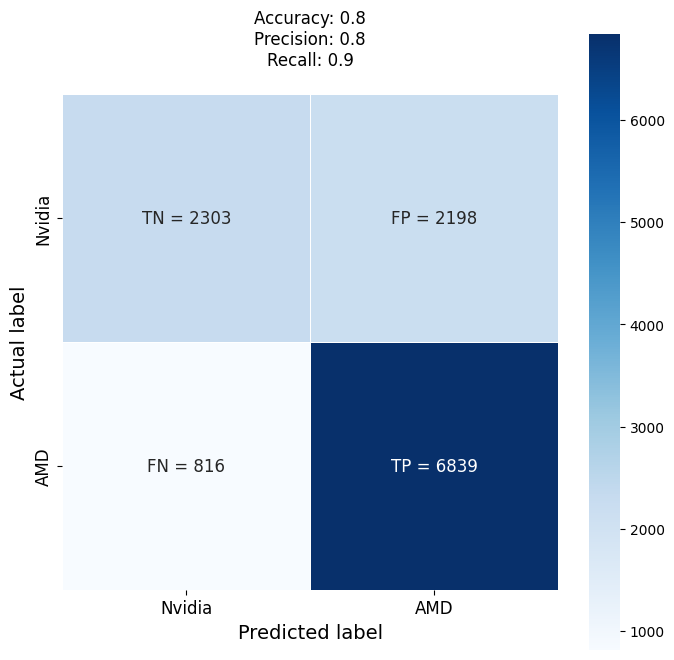

In [75]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 12},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Nvidia', 'AMD'],   #is_amd = 1
            yticklabels = ['Nvidia', 'AMD'],
            );

plt.ylabel('Actual label', fontsize = 14);
plt.xlabel('Predicted label', fontsize = 14);
plt.title('Accuracy: {:.1f}'.format(score)+'\n'
          +'Precision: {:.1f}'.format(prec)+'\n'
          +'Recall: {:.1f}'.format(recall)+'\n', size = 12);
plt.tick_params(labelsize= 12)

#### 3.2 AUC ROC Curve
ROC is a probability curve and AUC represents the degree or measure of separability - hence telling us how capable the model is in distinguishing between the two classes - in our case, whether it is from AMD or Nvidia subreddit. A value of 1 represents a perfect separation of the population, while 0.5 is the worst score, meaning the populations pefectly overlap.

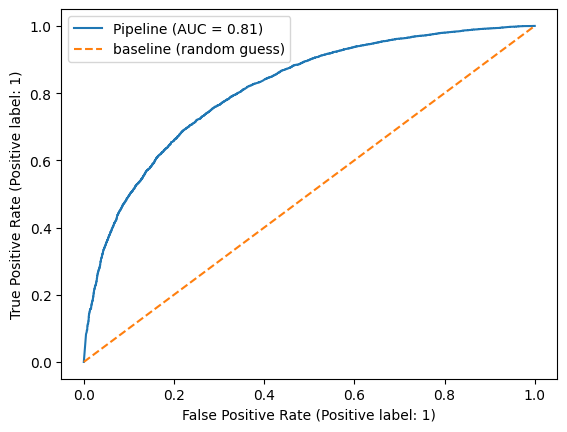

In [39]:
roc_display = RocCurveDisplay.from_estimator(best_estimator, X_test, y_test)
plt.plot([0, 1], [0, 1], label='baseline (random guess)', linestyle='--')
plt.legend()


In this case, we have an ROC AUC of 0.81 which is relatively close to 1 and thus I am satisfied with the model. It can separate positive and negative population relatively well.

### 4. Final Summary

#### Modelling

**Conclusion**: <br>
Logistic Regression with TFIFD Vectorizer is the best model, with **f1-score of 82%**, **ROC AUC score of 71%** and **test data accuracy of 75**%. It is good enough to classify whether a post belongs to r/AMD or r/Nvidia. Train data accuracy was observed to be 85%, hence only slight overfitting. <br>
In summary, the best parameters are:
- Model: Logistic Regression
- Transformer: TFIFD Vectorizer
- Max Features: None
- Max_df = 0.75: ignore terms that appear in more than 75% of the documents
- Min_df = 2: term must appear in at least 2 documents 
- Bigrams



#### Sentiment Analysis *(ref Notebook 2)*

**Conclusion**: The proportion of negative posts in r/AMD (27%), is **35%** higher than in r/Nvidia (20%) using VADER. Popular negative n-grams in AMD such as "high, idle, power" and "power, consumption", while positive n-grams in Nvidia like "better, image, quality" and "high, refresh, rate" clearly show that there is a clear difference in quality of AMD vs Nvidia products. There is likely a genuine issue with AMD products.<br><br>

**Recommendations**:

1. Allocation of more Engineering Resources:  Based on the sentiment analysis findings, the recommendation is made to allocate more engineering resources to improve the technical quality of AMD products. Particular attention is suggested for areas like image quality and power consumption.
2. Sentiment Monitoring:  Conduct comprehensive testing methods or soft launches to gather sentiments before launching new products. This proactive approach can help AMD address issues early in the development process.
3. Benchmarking:  AMD can consider benchmarking their products against Nvidia's products to gain insights and competitive advantages.

#### Future Steps
1. Collect More Data: Gather additional Reddit post data / data from other sources to increase the size and diversity of dataset. This can help improve the performance of your classification models and sentiment analysis.
2. Market Research: Conducting market research in addiition to the findings will give more contextual knowledge and increase awareness of certain terminology, or machine learning techniques that might be more targeted.
3. Advanced NLP techniques: Pre-trained models like BERT, or Convolutional Neural Networks (CNNs), which is a deep learning algorithm and will be useful to capture local patterns or n-grams in the text. CNNs are commonly used for tasks like sentiment analysis or text categorization.
